In [1]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 107.8 MB/s eta 0:00:0000:01


In [2]:
import time
import os
import shutil
from itertools import islice
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import findspark
findspark.init()

from google.cloud import storage

spark = SparkSession.builder \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.maxResultSize", "16g") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "4") \
    .config("spark.dynamicAllocation.maxExecutors", "100") \
    .getOrCreate()



spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.repl.eagerEval.maxCharsPerCell", 200)

print(spark.version)

3.1.3


In [12]:
# Read into spark df

%time commits_spDf = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/commits")
%time languages_spDf = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/languages")

CPU times: user 0 ns, sys: 4.21 ms, total: 4.21 ms
Wall time: 583 ms
CPU times: user 0 ns, sys: 3.16 ms, total: 3.16 ms
Wall time: 461 ms


In [9]:
from pyspark.sql.functions import col, lit, unix_timestamp

# Convert cutoff_date to epoch time
cutoff_date_epoch = unix_timestamp(lit("2022-11-27"), "yyyy-MM-dd")

# Filter based on the author and committer date.seconds field
commits_spDf = commits_spDf.filter(
    (col("author.date.seconds") < cutoff_date_epoch) & 
    (col("committer.date.seconds") < cutoff_date_epoch)
)

# Show schema and first rows for validation
%time commits_spDf.printSchema()
%time commits_spDf.limit(5)

root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- parent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- committer: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- trailer: array (nullable = true)
 |    |-- element: struct (contains

commit,tree,parent,author,committer,subject,message,trailer,difference,difference_truncated,repo_name,encoding
539e820d1f47ab000...,7b016212a8effd8de...,[d0f1ba9d57be06d5...,"{niallg, 99afbe04...","{niallg, 99afbe04...",Add documentaton ...,Add documentaton ...,[],[],null,[ngallagher/simpl...,null
1e02febc7721b9a6a...,4da857f23cdaf31f2...,[f185449a4972b9ca...,"{atrick, 6050ac38...","{atrick, 6050ac38...",Fix the LoopUnrol...,Fix the LoopUnrol...,[],[],null,[tarunprabhu/Drag...,null
f76e97a955764ea7a...,a26fff699e78646a6...,[491a39e51bc2ffc4...,"{tom7, 3ee31f81e2...","{tom7, 3ee31f81e2...",add some stray fi...,add some stray fi...,[],[],null,[JoeOsborn/tom7-f...,null
ad46fa7c0d31aaf20...,b13d1f8fb71b0c0b4...,[52e37ae4670a32b4...,"{Peter Loan, ec48...","{Peter Loan, ec48...",Added more dynami...,Added more dynami...,"[{git-svn-id, 9e0...",[],null,[opensim-org/open...,null
0e2980f47a12f1f2a...,f27af58144d187ac6...,[37075e68df7eec36...,"{Adam Dangoor, 74...","{Adam Dangoor, 74...",Empty for TC [ski...,Empty for TC [ski...,[],[],null,[adamtheturtle/vw...,null


In [ ]:
# Save the filtered commits file in gcp bucket
bucket_write = "gs://msca-bdp-students-bucket/shared_data/xiuan/commits_filtered.parquet"

# Write the DataFrame to GCS as a Parquet file
%time commits_spDf.write \
    .mode("overwrite") \
    .parquet(bucket_write)

print(f"DataFrame successfully written to {bucket_write}")

## Re-read from save

In [3]:
bucket_write = "gs://msca-bdp-students-bucket/shared_data/xiuan/commits_filtered.parquet"
commits_spDf = spark.read.parquet(bucket_write)

In [6]:
from pyspark.sql.functions import explode, col

# Step 1: Explode repo_name in commits_spDf
commits_exploded = commits_spDf.withColumn("repo_name_exploded", explode(col("repo_name")))

commits_exploded.printSchema()

root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- parent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- committer: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- trailer: array (nullable = true)
 |    |-- element: struct (contains

In [7]:
from pyspark.sql.functions import col, when, lower

# Add a new column for categories based on the `subject` field
categorized_df = commits_spDf.withColumn(
    "category",
    when(lower(col("subject")).contains("fix"), "Bug Fix")
    .when(lower(col("subject")).contains("add"), "Feature Development")
    .when(lower(col("subject")).contains("update"), "Update")
    .when(lower(col("subject")).contains("refactor"), "Refactoring")
    .when(lower(col("subject")).contains("test"), "Testing")
    .otherwise("Other")
)

# Show sample data
categorized_df.select("subject", "category").limit(5)

subject,category
Updated the qceng...,Update
Merge remote-trac...,Bug Fix
provide hook to o...,Other
Updated the mailc...,Update
2014-03-06T04:30,Other


In [8]:
from pyspark.sql.functions import count

# Group by category and count
category_counts = categorized_df.groupBy("category").agg(count("*").alias("count"))

# Sort by count in descending order
category_counts = category_counts.orderBy(col("count").desc())

# Show the most frequent categories
category_counts.limit(5)

category,count
Other,148681871
Feature Development,40029058
Bug Fix,35374769
Update,30966117
Testing,7800225


In [9]:
rows = category_counts.count()
print(f"Total rows in table: {rows}")

Total rwos in table: 6


In [11]:
category_counts_pd = category_counts.toPandas()

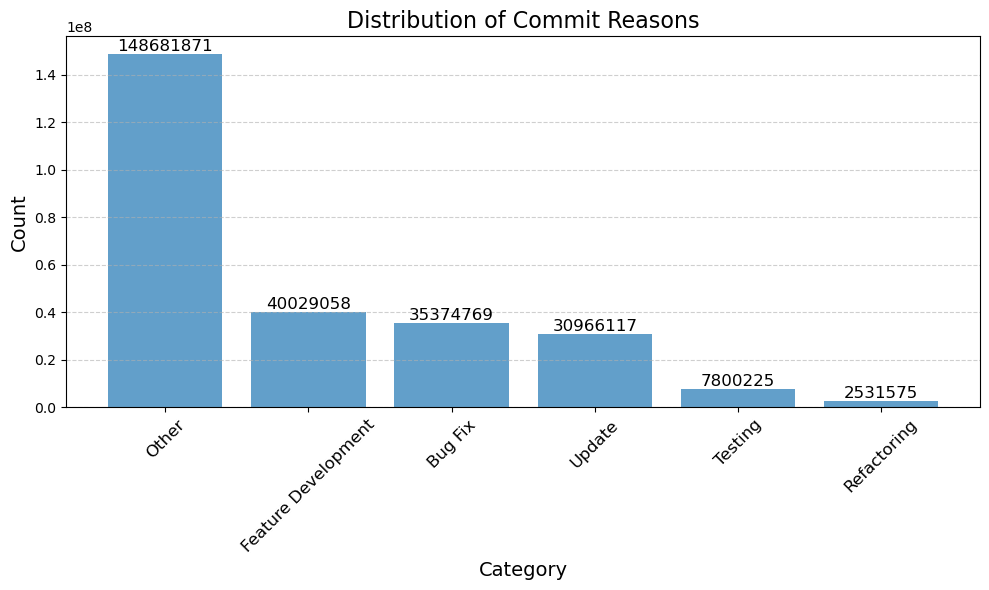

24/12/12 20:28:02 ERROR org.apache.spark.network.client.TransportResponseHandler: Still have 1 requests outstanding when connection from /10.128.1.88:33732 is closed
24/12/12 20:28:02 ERROR org.apache.spark.network.client.TransportClient: Failed to send RPC RPC 7759331176453423968 to /10.128.1.88:33732: java.nio.channels.ClosedChannelException
java.nio.channels.ClosedChannelException
	at io.netty.channel.AbstractChannel$AbstractUnsafe.newClosedChannelException(AbstractChannel.java:957)
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(AbstractChannel.java:865)
	at io.netty.channel.DefaultChannelPipeline$HeadContext.write(DefaultChannelPipeline.java:1367)
	at io.netty.channel.AbstractChannelHandlerContext.invokeWrite0(AbstractChannelHandlerContext.java:717)
	at io.netty.channel.AbstractChannelHandlerContext.invokeWriteAndFlush(AbstractChannelHandlerContext.java:764)
	at io.netty.channel.AbstractChannelHandlerContext.write(AbstractChannelHandlerContext.java:790)
	at io.netty.chan

In [12]:
plt.figure(figsize=(10, 6))
bars = plt.bar(category_counts_pd['category'], category_counts_pd['count'], alpha=0.7)

# Add data points on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title('Distribution of Commit Reasons', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

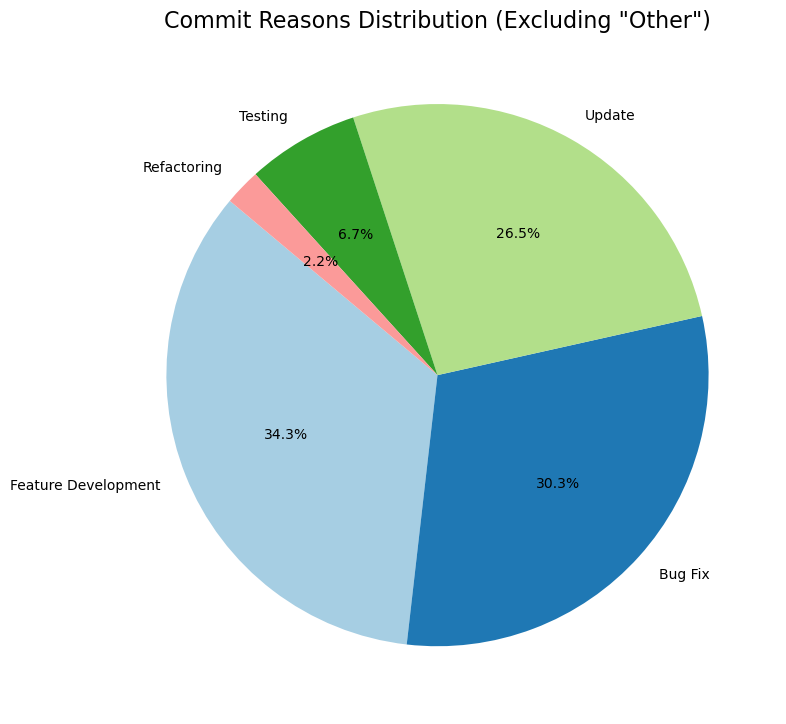

In [14]:
# Filter out the "Other" category
filtered_data = category_counts_pd[category_counts_pd['category'] != "Other"]

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    filtered_data['count'], 
    labels=filtered_data['category'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.Paired.colors
)

# Add title
plt.title('Commit Reasons Distribution (Excluding "Other")', fontsize=16)
plt.tight_layout()
plt.show()

# Prolific Committer 

In [15]:
committer_counts = commits_spDf.groupBy("committer.name").agg(count("*").alias("commit_count"))

# Sort the results in descending order of commit count
committer_counts = committer_counts.orderBy(col("commit_count").desc())

# Show the top committers
committer_counts.show(10, truncate=False)

+--------------------+------------+
|name                |commit_count|
+--------------------+------------+
|GitHub              |21511216    |
|Duane F. King       |597940      |
|Gerrit Code Review  |597186      |
|devs-mycroft        |524440      |
|Marge Spiderworthy  |495786      |
|Commit Bot          |421632      |
|Curt Clifton        |384915      |
|James Michael DuPont|343198      |
|CI Pool Resource    |316075      |
|root                |313445      |
+--------------------+------------+
only showing top 10 rows



In [17]:
# Check if size is appropriate to Pandas
rows = committer_counts.count()


Total table rows {rows}


In [18]:
print(f"Total table rows {rows}")

Total table rows 2528482


In [20]:
# Turn top 50 committers into pandas df
top_committer = committer_counts.limit(50).toPandas()

In [21]:
top_committer.head(5)

,name,commit_count
0,GitHub,21511216
1,Duane F. King,597940
2,Gerrit Code Review,597186
3,devs-mycroft,524440
4,Marge Spiderworthy,495786


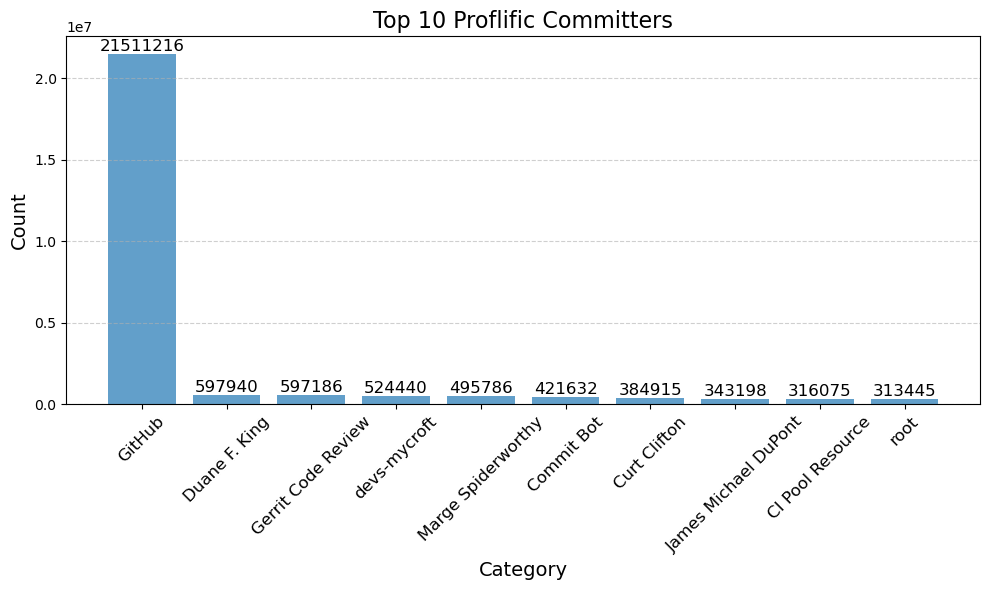

In [24]:
top_committer_top = top_committer.head(10)
plt.figure(figsize=(10, 6))
bars = plt.bar(top_committer_top['name'], top_committer_top['commit_count'], alpha=0.7)

# Add data points on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=12)

# Add labels and title
plt.title('Top 10 Proflific Committers', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# License distribution
What is the distribution of licenses across GitHub repositories?
Any certain programming languages that are more likely to be associated with a particular license?

In [ ]:
license_count = license_spDf.withColumn("Count",count('License'))
license_count.to_Panda()